<a href="https://colab.research.google.com/github/Abhishek1236/time-series-research-sktime/blob/main/baseline_lstm_medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from datetime import datetime,timedelta
import datetime 



In [3]:
data = pd.read_excel('/content/Event.xlsx')

In [4]:
df_medium = data[['Date','MEDIUM']]

In [5]:
df_medium.head()

,Date,MEDIUM
0,2012-01-01,50
1,2012-01-02,52
2,2012-01-04,52
3,2012-01-05,50
4,2012-01-06,50


In [6]:
med_data = df_medium['MEDIUM'].values

In [7]:
med_data_copy = med_data.copy()

In [8]:
med_for_scale = med_data.reshape(-1,1)

In [9]:
scaler = StandardScaler()
scaler = scaler.fit(med_for_scale)
df_med = scaler.transform(med_for_scale)

In [10]:
df_med

array([[-1.78655062],
       [-1.65725989],
       [-1.65725989],
       ...,
       [-1.39867842],
       [-1.39867842],
       [-1.39867842]])

In [11]:
Train = []
Test = []
n_future = 1
n_past = 40
for i in range(n_past,len(df_med),n_future+1):
  Train.append(df_med[i-n_past:i,0:df_med.shape[1]])
  Test.append(df_med[i + n_future - 1:i + n_future,0])

Train,Test = np.array(Train),np.array(Test)

In [12]:
'''
size = len(df_med)
training_size = int(size - (0.8*size))
x_train,y_train = Train[:training_size],Train[training_size:]
x_test,y_test = Test[:training_size],Test[training_size:]
'''

In [18]:
#Building the model 
model = Sequential()
model.add(LSTM(64,activation = 'relu',input_shape = (Train.shape[1],Train.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(Test.shape[1]))
model.compile(optimizer='adam',loss = 'mse')
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 40, 64)            16896     
_________________________________________________________________
lstm_15 (LSTM)               (None, 40, 32)            12416     
_________________________________________________________________
dropout_7 (Dropout)          (None, 40, 32)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
__________________________________________________

In [19]:
history = model.fit(Train,Test,epochs=15,batch_size=16,validation_split=0.25,verbose=2)

Epoch 1/15
67/67 - 6s - loss: 0.4397 - val_loss: 1.4524
Epoch 2/15
67/67 - 3s - loss: 0.2570 - val_loss: 0.4810
Epoch 3/15
67/67 - 3s - loss: 0.2279 - val_loss: 0.3223
Epoch 4/15
67/67 - 3s - loss: 0.2044 - val_loss: 0.3072
Epoch 5/15
67/67 - 3s - loss: 0.2051 - val_loss: 0.3005
Epoch 6/15
67/67 - 3s - loss: 0.1959 - val_loss: 0.2507
Epoch 7/15
67/67 - 3s - loss: 0.1797 - val_loss: 0.2925
Epoch 8/15
67/67 - 3s - loss: 0.1873 - val_loss: 0.2907
Epoch 9/15
67/67 - 3s - loss: 0.1664 - val_loss: 0.2293
Epoch 10/15
67/67 - 3s - loss: 0.1628 - val_loss: 0.2412
Epoch 11/15
67/67 - 3s - loss: 0.1627 - val_loss: 0.2511
Epoch 12/15
67/67 - 3s - loss: 0.1439 - val_loss: 0.1908
Epoch 13/15
67/67 - 3s - loss: 0.1408 - val_loss: 0.1826
Epoch 14/15
67/67 - 3s - loss: 0.1333 - val_loss: 0.1568
Epoch 15/15
67/67 - 3s - loss: 0.1293 - val_loss: 0.1951


In [21]:
model.save('baseline.h5')

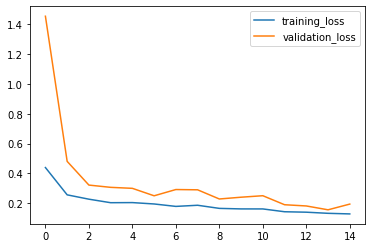

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label = 'training_loss')
plt.plot(history.history['val_loss'],label = 'validation_loss')
plt.legend()

In [31]:
train_data_dates = df_medium['Date']

In [36]:
n_future = 40
forecast_period_dates = pd.date_range(list(train_data_dates)[-1],periods=n_future,freq='1d').tolist()
forecast = model.predict(Train[-n_future:])

In [39]:
forecast_dates = []
for i in forecast_period_dates:
  forecast_dates.append(i.date())

In [ ]:
y_pred = scaler.inverse_transform(forecast)
y_pred

In [48]:
dates = pd.DataFrame(forecast_dates,columns=['Date'])
predi = pd.DataFrame(y_pred,columns=['Medium'])
predi['Medium'] = (predi['Medium']).astype(int)
med_predicted = pd.concat([dates,predi],axis = 1)

In [49]:
med_predicted.head()

,Date,Medium
0,2021-01-31,84
1,2021-02-01,84
2,2021-02-02,89
3,2021-02-03,90
4,2021-02-04,93


In [50]:
med_predicted.to_excel('baseline_lstm.xlsx')